<>:8: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Moaz\AppData\Local\Temp\ipykernel_192164\1695081719.py:8: SyntaxWarning: invalid escape sequence '\M'
  folder_path = "D:\Moaz\Saphone\image\Gravity Falls\Gravity Falls\puzzle_2x2"


Folder exists: True


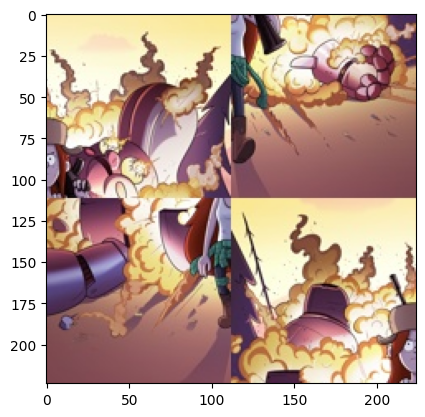

In [13]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np


folder_path = "D:\Moaz\Saphone\image\Gravity Falls\Gravity Falls\puzzle_2x2"
print("Folder exists:", os.path.exists(folder_path))  # Debug

image_paths = glob.glob(os.path.join(folder_path, "*.jpg")) \
             + glob.glob(os.path.join(folder_path, "*.png")) \
             + glob.glob(os.path.join(folder_path, "*.jpeg"))


img = cv2.imread(image_paths[3])

# You must add this step before using plt.imshow
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

plt.imshow(img_rgb)
plt.show()


In [7]:
se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 1))

#Pipeline
def pipeline(imgPath):
  h, w = img.shape[:2]
  center_x, center_y = w // 2, h // 2
  img = cv2.imread(imgPath)
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gauss = cv2.GaussianBlur(grayImg, (11,11), 0)
  equalized = cv2.equalizeHist(gauss)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  edges = cv2.Canny(
    image=equalized,
    threshold1=50,   # lower threshold
    threshold2=150   # upper threshold
)
  closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, se_rect)
  dilated_edges = cv2.dilate(closed_edges, se_rect, iterations=1)

  ax1.imshow(img, cmap="gray")
  ax2.imshow(dilated_edges, cmap="gray")
  contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Output folder
  output_folder = "/content/puzzle_pieces"
  os.makedirs(output_folder, exist_ok=True)

  saved_count = 0
  for i, c in enumerate(contours):
      if cv2.contourArea(c) < 500:  # filter small noise
          continue

      # Get bounding box
      x, y, w, h = cv2.boundingRect(c)

      # Make mask of same size as bounding box (not whole image)
      mask = np.zeros((h, w), dtype=np.uint8)
      # Draw contour shifted to top-left corner of bbox
      c_shifted = c - [x, y]
      cv2.drawContours(mask, [c_shifted], -1, 255, thickness=cv2.FILLED)

      # Crop the image to bounding box
      piece = img[y:y+h, x:x+w]
      # Apply mask
      piece_masked = cv2.bitwise_and(piece, piece, mask=mask)

      # Save
      filename = os.path.join(output_folder, f"piece_{saved_count}.png")
      cv2.imwrite(filename, piece_masked)
      saved_count += 1

  print(f"Saved {saved_count} pieces to {output_folder}")

pipeline(image_paths[3])



UnboundLocalError: cannot access local variable 'img' where it is not associated with a value

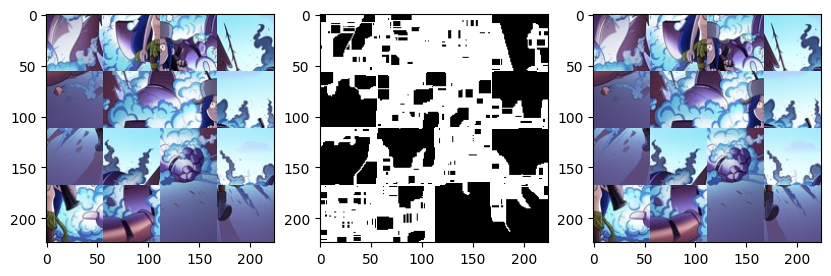

In [4]:
se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
se_rect2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 11))

#Pipeline
def pipeline2(imgPath):
  img = cv2.imread(imgPath)
  h, w = img.shape[:2]
  center_x, center_y = w // 2, h // 2
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bilateral = cv2.bilateralFilter(grayImg, 11 ,20 , 100)
  fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(10, 5))
  edges = cv2.Canny(
    image=bilateral,
    threshold1=50,   # lower threshold
    threshold2=150   # upper threshold
)
  edges_closedH = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, se_rect)
  edges_closedV = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, se_rect2)
  edges_closed = np.bitwise_or(edges_closedV, edges_closedH)
  lines = cv2.HoughLinesP(
    edges_closed,
    rho=1,
    theta=np.pi/180,
    threshold=90,
    minLineLength=int(img.shape[1] * 0.3),
    maxLineGap=30
)
  line_display_img = img.copy()

  if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate line properties
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        length = np.sqrt(dx**2 + dy**2)

        # Skip very short lines (adjust threshold as needed)
        if length < min(w, h) * 0.05:
            continue

        # Calculate angle from horizontal in degrees
        angle = np.degrees(np.arctan2(dy, dx))

        # Line midpoint
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2

        # Check if line is vertical (angle close to 90 degrees, within 10 degree tolerance)
        if angle > 80 and angle < 100:
            # Check if midpoint X is near center
            if abs(mid_x - center_x) < (w * 0.15):
                cv2.line(line_display_img, (x1, y1), (x2, y2), (0, 0, 255), 1)  # Red

        # Check if line is horizontal (angle close to 0 degrees, within 10 degree tolerance)
        elif angle < 10 or angle > 170:
            # Check if midpoint Y is near center
            if abs(mid_y - center_y) < (h * 0.15):
                cv2.line(line_display_img, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Green
  ax1.imshow(img, cmap="gray")
  ax2.imshow(edges_closed, cmap="gray")
  ax3.imshow(line_display_img , cmap = "gray")
  # contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)




pipeline2(image_paths[3])



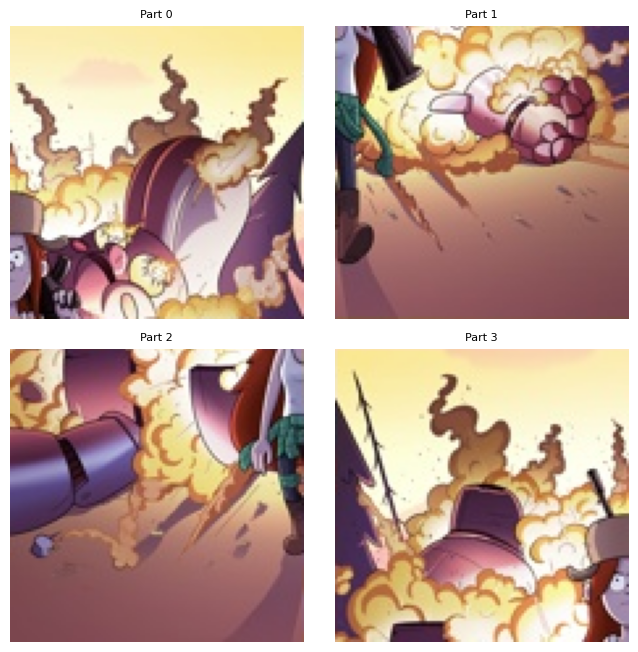

Total pieces: 4
Shape of first piece: (112, 112, 3)


In [14]:
import cv2
import matplotlib.pyplot as plt

def show_puzzle_pieces(imgPath):
    # 1. Load Image
    img = cv2.imread(imgPath)
    # Convert BGR (OpenCV default) to RGB (Matplotlib default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w, c = img_rgb.shape
    
    # 2. Calculate dimensions for a 4x4 grid
    # Using integer division // to get whole numbers
    piece_h = h // 2
    piece_w = w // 2
    
    # List to store the actual image arrays
    pieces_array = []
    
    # 3. Setup the visualization plot (4 rows, 4 columns)
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    # Adjust spacing so you can see the cuts (wspace/hspace > 0 creates the gap)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # 4. Loop to cut and display
    count = 0
    for i in range(2):      # Rows
        for j in range(2):  # Columns
            
            # Calculate start/end coordinates
            y1 = i * piece_h
            y2 = (i + 1) * piece_h
            x1 = j * piece_w
            x2 = (j + 1) * piece_w
            
            # Fix for remaining pixels on the edges (if image isn't perfectly divisible by 4)
            if i == 1: y2 = h
            if j == 1: x2 = w
            
            # --- THE CUT ---
            # Numpy slicing: [start_row:end_row, start_col:end_col]
            piece = img_rgb[y1:y2, x1:x2]
            
            # Store in our list
            pieces_array.append(piece)
            
            # Display in the subplot
            axes[i, j].imshow(piece)
            axes[i, j].axis('off') # Turn off axis numbers
            axes[i, j].set_title(f"Part {count}", fontsize=8)
            count += 1

    plt.show()
    
    return pieces_array

# Usage
# This returns a list containing 16 numpy arrays (images)
all_pieces = show_puzzle_pieces(image_paths[3])

# To verify, you can access a specific piece from the array:
print(f"Total pieces: {len(all_pieces)}")
print(f"Shape of first piece: {all_pieces[0].shape}")